# Import Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

df = pd.read_csv('listings_cleaned.csv')
df.head(5)

,id,name,description,neighborhood_overview,host_since,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,...,estimated_revenue_l365d,instant_bookable,average_review_score,reviews_per_year,max_host_response_time_hours,host_has_about,neighborhood_has_overview,host_location_provided,host_profile_score,amenities_count
0,13188,Garden level studio in ideal loc.,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,2009-11-04,"Vancouver, Canada",I love to travel with my family in comfort and...,1.0,1.0,True,...,35955.0,False,4.872857,24.061094,1.0,True,True,True,4,59
1,13358,Downtown Designer one bedroom,The iconic Electra Building.<br />A Vancouver ...,2 blocks away from the shopping area of Robson...,2009-11-07,"Vancouver, Canada",I am from Vancouver and in my free time I enjo...,1.0,1.0,True,...,69870.0,True,4.787143,38.331584,1.0,True,True,True,4,43
2,18270,private rm in clean central 2BR apt,I have a bright furnished 2 bedroom suite on a...,"Lots of restaurants, coffee shops.<br />Easy a...",2010-01-14,"Vancouver, Canada",In my spare time I am pretty active - currentl...,NaN,NaN,False,...,0.0,False,4.525714,13.422454,NaN,True,True,True,4,23
3,18589,Commercial Drive B&B,"As hosts, we are welcoming you into our home, ...",Lots of restaurants and boutiques just outside...,2010-01-18,"Vancouver, Canada",We - Alexis and Sylvain - are the Artistic Dir...,1.0,1.0,True,...,40800.0,False,4.972857,43.485504,1.0,True,True,True,4,49
4,18795,*Best choice in downtown-5 Stars * -2,NaN,No description provided,2010-01-13,"Vancouver, Canada",Hi Dear Guests. House i is a company operating...,0.0,1.0,True,...,0.0,False,4.612857,10.837542,168.0,True,False,True,4,17


# OG Linear Regression Model

In [3]:
# Bring out Linear Regression Model from last notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Use UNIQUE variable names for price model
price_target = 'price'
price_numerical_features = [
    'accommodates', 
    'bedrooms', 
    'beds', 
    'bathrooms', 
    'number_of_reviews', 
    'average_review_score', 
    'availability_365', 
    'host_total_listings_count'
]
price_categorical_features = [
    'property_type', 
    'room_type', 
    'neighbourhood_cleansed'
]

# Create price model dataframe
price_features = price_numerical_features + price_categorical_features
price_model_df = df[price_features + [price_target]].copy()

# Fill missing values
for col in price_numerical_features:
    median_val = price_model_df[col].median()
    price_model_df[col] = price_model_df[col].fillna(median_val)

for col in price_categorical_features:
    mode_val = price_model_df[col].mode()[0]
    price_model_df[col] = price_model_df[col].fillna(mode_val)

# One-hot encode
price_model_df_encoded = pd.get_dummies(
    price_model_df, 
    columns=price_categorical_features, 
    drop_first=True
)

# Define X and y for PRICE model
price_y = price_model_df_encoded[price_target]
price_X = price_model_df_encoded.drop(columns=[price_target])

# Split data

price_X_train, price_X_test, price_y_train, price_y_test = train_test_split(
    price_X, price_y, test_size=0.25, random_state=0
)

print(f"Price Model - Training with {price_X_train.shape[1]} features.")

# Train model
price_lin_reg = LinearRegression()
price_lin_reg.fit(price_X_train, price_y_train)

# Evaluate
price_predictions = price_lin_reg.predict(price_X_test)
price_rmse = np.sqrt(mean_squared_error(price_y_test, price_predictions))
price_r2 = r2_score(price_y_test, price_predictions)

print(f"Root Mean Squared Error (RMSE): ${price_rmse:.2f}")
print(f"R2-Square: {price_r2:.2f}")
print(f"\nRMSE: On average, the model's price predictions are off by about ${price_rmse:.2f}.")
print(f"R2-Square: The model explains about {price_r2*100:.1f}% of the variance in the price.")


Price Model - Training with 75 features.
Root Mean Squared Error (RMSE): $188.72
R2-Square: 0.46

RMSE: On average, the model's price predictions are off by about $188.72.
R2-Square: The model explains about 46.1% of the variance in the price.


In [4]:
#Feature Importance
feature_importance = pd.DataFrame(
    {
        'feature': price_X.columns,
        'coefficient': price_lin_reg.coef_
    }
).sort_values('coefficient', ascending=False)

feature_importance.head(10)


,feature,coefficient
33,property_type_Private room in serviced apartment,504.696282
16,property_type_Entire place,289.847778
24,property_type_Private room in boat,285.473636
30,property_type_Private room in hostel,113.288617
20,property_type_Entire vacation home,92.918678
3,bathrooms,79.061188
40,property_type_Room in hotel,68.026366
53,neighbourhood_cleansed_Downtown,62.929963
73,neighbourhood_cleansed_West End,58.784642
54,neighbourhood_cleansed_Downtown Eastside,45.368632


## Testing Box

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

# FREEZE feature names for price model
PRICE_FEATURE_NAMES = price_X_train.columns.tolist().copy()

# Get options for dropdowns
price_property_types = sorted(price_model_df['property_type'].dropna().unique().tolist())
price_room_types = sorted(price_model_df['room_type'].dropna().unique().tolist())
price_neighbourhoods = sorted(price_model_df['neighbourhood_cleansed'].dropna().unique().tolist())

print(f"\n Price model ready with {len(PRICE_FEATURE_NAMES)} features")


def predict_price(accommodates, bedrooms, beds, bathrooms, 
                  number_of_reviews, average_review_score, availability_365,
                  host_total_listings_count, property_type, 
                  room_type, neighbourhood_cleansed):
    
    # Create input
    input_data = pd.DataFrame({
        'accommodates': [float(accommodates)],
        'bedrooms': [float(bedrooms)],
        'beds': [float(beds)],
        'bathrooms': [float(bathrooms)],
        'number_of_reviews': [float(number_of_reviews)],
        'average_review_score': [float(average_review_score)],
        'availability_365': [float(availability_365)],
        'host_total_listings_count': [float(host_total_listings_count)],
        'property_type': [property_type],
        'room_type': [room_type],
        'neighbourhood_cleansed': [neighbourhood_cleansed]
    })
    
    # One-hot encode
    input_encoded = pd.get_dummies(
        input_data, 
        columns=['property_type', 'room_type', 'neighbourhood_cleansed'],
        drop_first=True
    )
    
    # Align with trained model features
    final_input = pd.DataFrame(
        np.zeros((1, len(PRICE_FEATURE_NAMES))), 
        columns=PRICE_FEATURE_NAMES,
        dtype=np.float64
    )
    
    for col in input_encoded.columns:
        if col in PRICE_FEATURE_NAMES:
            final_input[col] = input_encoded[col].values[0]
    
    # Predict using PRICE model
    prediction = price_lin_reg.predict(final_input)
    print(f"  Predicted Price: ${prediction[0]:.2f}")
    return prediction[0]


# Create widget
print("\n" + "="*60)
print("PRICE PREDICTION WIDGET")
print("="*60)

interact(
    predict_price,
    accommodates = widgets.IntSlider(value=2, min=1, max=16, step=1, description='Accommodates:', continuous_update=False),
    bedrooms = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=1.0, description='Bedrooms:', continuous_update=False),
    beds = widgets.FloatSlider(value=1.0, min=0.0, max=16.0, step=1.0, description='Beds:', continuous_update=False),
    bathrooms = widgets.FloatSlider(value=1.0, min=0.5, max=8.0, step=0.5, description='Bathrooms:', continuous_update=False),
    number_of_reviews = widgets.IntSlider(value=20, min=0, max=500, step=5, description='Reviews:', continuous_update=False),
    average_review_score = widgets.FloatSlider(value=4.5, min=0.0, max=5.0, step=0.1, description='Review Score:', continuous_update=False),
    availability_365 = widgets.IntSlider(value=100, min=0, max=365, step=10, description='Availability:', continuous_update=False),
    host_total_listings_count = widgets.IntSlider(value=1, min=0, max=50, step=1, description='Host Listings:', continuous_update=False),
    property_type = widgets.Dropdown(options=price_property_types, value=price_property_types[0], description='Property Type:'),
    room_type = widgets.Dropdown(options=price_room_types, value=price_room_types[0], description='Room Type:'),
    neighbourhood_cleansed = widgets.Dropdown(options=price_neighbourhoods, value=price_neighbourhoods[0], description='Neighbourhood:')
);


 Price model ready with 75 features

PRICE PREDICTION WIDGET


interactive(children=(IntSlider(value=2, continuous_update=False, description='Accommodates:', max=16, min=1),…

# Hyperparameter work

## Step 3b: Handle Imblance/Skew first

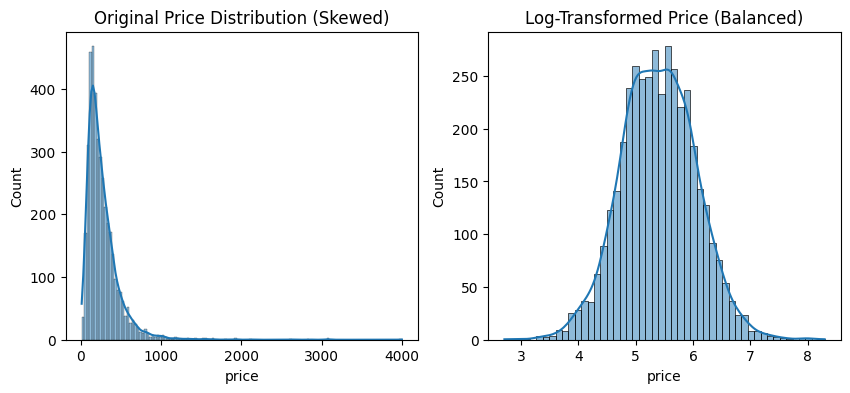

Transformation complete. We will use 'y_log' as our target for tuning.
This satisfies Section 3b: Stabilizing variance and reducing outlier influence.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Visualize the "Imbalance" (Skewed Price)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(price_model_df_encoded['price'], kde=True)
plt.title("Original Price Distribution (Skewed)")

# 2. Apply Log Transformation (The "Balancing" Technique)
# We use log1p (log(1+x)) to avoid errors with 0 values
# This compresses the massive outliers (e.g., $5000) into a manageable range
y_log = np.log1p(price_model_df_encoded['price'])

# 3. Visualize the Result
plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True)
plt.title("Log-Transformed Price (Balanced)")
plt.show()

print("Transformation complete. We will use 'y_log' as our target for tuning.")
print("This satisfies Section 3b: Stabilizing variance and reducing outlier influence.")

In [8]:
#Create Test Train using log transformed target
from sklearn.model_selection import train_test_split

price_X_train, price_X_test, y_train_log, y_test_log = train_test_split(
    price_X, y_log, test_size=0.25, random_state=0
)

print("  Created log-transformed training sets.")
print(f"Original Max Price in Train: ${price_y_train.max()}")
print(f"Log Max Price in Train:      {y_train_log.max():.4f} (approx ${np.expm1(y_train_log.max()):.0f})")


  Created log-transformed training sets.
Original Max Price in Train: $3086.0
Log Max Price in Train:      8.0350 (approx $3086)


## Model 1: Linear/Ridge Regression

### 1. Hyperparameter Explanation (5 points)

Note. Technically, there's no need to do any hyperparameter work for Linear Regression because Linear Regression is , mathematically, "already optimized". To quote Geeks and Geeks:

```

For standard linear regression, there are no hyperparameters to tune. However, when we extend linear regression to include regularization techniques such as Ridge Regression https://www.geeksforgeeks.org/machine-learning/hyperparameter-tuning-in-linear-regression/
...
It seems that sklearn.linear_model.LinearRegression does not have hyperparameters that can be tuned. So, instead please use sklearn.linear_model.SGDRegressor, which will provide many possiblites for tuning hyperparameters. Its documentation can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html .

```

But I do wanna include some variation of Linear. So I am adjusting it to become Ridge Regression.

For Ridge Regression, we tune the following hyperparameters:

1. **alpha (Regularization Strength)**
   - What it controls: The amount of L2 regularization penalty applied to coefficients
   - Impact on complexity: 
     * Higher alpha = simpler model (coefficients shrink toward zero)
     * Lower alpha = more complex model (similar to standard linear regression)
   - Overfitting vs Underfitting:
     * Too low alpha → Overfitting (model fits training noise)
     * Too high alpha → Underfitting (model too simple, misses patterns)
   - Why it matters for our dataset:
     * We have 75 features (after one-hot encoding)
     * Many features may be correlated (e.g., property types, neighborhoods)
     * Regularization prevents overfitting to specific property/neighborhood combinations
     * Helps the model generalize better to unseen listings

2. **solver (Optimization Algorithm)**
   - What it controls: The algorithm used to find optimal coefficients
   - Impact on complexity: Different solvers have different computational speeds
   - Options tested:
     * 'auto': Automatically chooses based on data
     * 'svd': Singular Value Decomposition (good for few features)
     * 'lsqr': Least Squares (good for large datasets)
     * 'saga': Stochastic gradient descent (fastest for very large datasets)
   - Why it matters for our dataset:
     * With 4000+ samples and 75 features, solver choice affects training speed
     * Some solvers handle multicollinearity better than others

Source: https://medium.com/data-science/hyperparameter-tuning-in-lasso-and-ridge-regressions-70a4b158ae6d

### 2. Hyperparameter Tuning

In [244]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
import time

print("2. HYPERPARAMETER TUNING")

2. HYPERPARAMETER TUNING


#### 2.1 GridSearchCV

In [245]:
print("2.1 GRID SEARCH CV")

# Define parameter grid
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],  # 7 values
    'solver': ['auto', 'svd', 'lsqr']  # 3 values
}
# Total combinations: 7 × 3 = 21 combinations × 5 folds = 105 fits

print(f"\nParameter Grid:")
print(f"  alpha: {ridge_param_grid['alpha']}")
print(f"  solver: {ridge_param_grid['solver']}")
print(f"\nTotal combinations: {len(ridge_param_grid['alpha']) * len(ridge_param_grid['solver'])}")
print(f"With 5-fold CV: {len(ridge_param_grid['alpha']) * len(ridge_param_grid['solver']) * 5} total fits")

# Initialize GridSearchCV
ridge_grid = GridSearchCV(
    estimator=Ridge(random_state=0),
    param_grid=ridge_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R² as the scoring metric
    n_jobs=-1,  # Use all CPU cores
    verbose=1,
    return_train_score=True
)

# Time the grid search
print("\n Running Grid Search... ")
start_time = time.time()
ridge_grid.fit(price_X_train, price_y_train)
grid_time = time.time() - start_time

print(f"\n Grid Search Complete")
print(f"   Time taken: {grid_time:.2f} seconds")
print(f"\n   Best Parameters: {ridge_grid.best_params_}")
print(f"   Best CV R² Score: {ridge_grid.best_score_:.4f}")

# Display results in a table
ridge_grid_results = pd.DataFrame(ridge_grid.cv_results_)
ridge_grid_summary = ridge_grid_results[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
print("\n   Top 5 Parameter Combinations:")
print(ridge_grid_summary.head().to_string(index=False))

2.1 GRID SEARCH CV

Parameter Grid:
  alpha: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
  solver: ['auto', 'svd', 'lsqr']

Total combinations: 21
With 5-fold CV: 105 total fits

 Running Grid Search... 
Fitting 5 folds for each of 21 candidates, totalling 105 fits

 Grid Search Complete
   Time taken: 5.65 seconds

   Best Parameters: {'alpha': 1.0, 'solver': 'auto'}
   Best CV R² Score: 0.5233

   Top 5 Parameter Combinations:
 param_alpha param_solver  mean_test_score  std_test_score  rank_test_score
        1.00         auto         0.523278        0.086010                1
        1.00          svd         0.523278        0.086010                2
        0.10          svd         0.522377        0.085187                3
        0.10         auto         0.522377        0.085187                4
        0.01          svd         0.522124        0.085051                5


#### 2.2 RandomizedSearchCV

In [246]:
print("2.2 RANDOMIZED SEARCH CV")
# Define parameter distributions
ridge_param_dist = {
    'alpha': uniform(0.001, 1000),  # Continuous distribution from 0.001 to 1000
    'solver': ['auto', 'svd', 'lsqr', 'saga']  # 4 options
}

print(f"\nParameter Distributions:")
print(f"  alpha: Uniform distribution [0.001, 1000]")
print(f"  solver: {ridge_param_dist['solver']}")
print(f"\nNumber of iterations: 30")
print(f"With 5-fold CV: {30 * 5} total fits")

# Initialize RandomizedSearchCV
ridge_random = RandomizedSearchCV(
    estimator=Ridge(random_state=0),
    param_distributions=ridge_param_dist,
    n_iter=50,  
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=0,
    return_train_score=True
)

# Time the random search
print("\n Running Randomized Search... ")
start_time = time.time()
ridge_random.fit(price_X_train, price_y_train)
random_time = time.time() - start_time

print(f"\n Randomized Search Complete")
print(f"   Time taken: {random_time:.2f} seconds")
print(f"\n   Best Parameters: {ridge_random.best_params_}")
print(f"   Best CV R² Score: {ridge_random.best_score_:.4f}")

# Display results
ridge_random_results = pd.DataFrame(ridge_random.cv_results_)
ridge_random_summary = ridge_random_results[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
print("\n   Top 5 Parameter Combinations:")
print(ridge_random_summary.head().to_string(index=False))

2.2 RANDOMIZED SEARCH CV

Parameter Distributions:
  alpha: Uniform distribution [0.001, 1000]
  solver: ['auto', 'svd', 'lsqr', 'saga']

Number of iterations: 30
With 5-fold CV: 150 total fits

 Running Randomized Search... 
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/media/waliz/D25C450F5C44EFB1/Users/waliz/Documents/Term 4/4880 - Data Analytics/Project/vancouver airbnb/coding/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/waliz/D25C450F5C44EFB1/Users/waliz/Documents/Term 4/4880 - Data Analytics/Project/vancouver airbnb/coding/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/waliz/D25C450F5C44EFB1/Users/waliz/Documents/Term 4/4880 - Data Analytics/Project/vancouver airbnb/coding/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/waliz/D25C450F5C44EFB1/Users/waliz/Documents/Term 4/4880 - Data Analytics/Project/vancouver airbnb/coding/venv/lib/python3.12/site-packages/sklearn


 Randomized Search Complete
   Time taken: 13.59 seconds

   Best Parameters: {'alpha': np.float64(56.71397731744318), 'solver': 'auto'}
   Best CV R² Score: 0.5170

   Top 5 Parameter Combinations:
 param_alpha param_solver  mean_test_score  std_test_score  rank_test_score
   56.713977         auto         0.517018        0.089155                1
   96.099408          svd         0.513362        0.088756                2
  118.275426         auto         0.511487        0.088452                3
  138.183951          svd         0.509900        0.088169                4
  158.970584          svd         0.508326        0.087874                5


/media/waliz/D25C450F5C44EFB1/Users/waliz/Documents/Term 4/4880 - Data Analytics/Project/vancouver airbnb/coding/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/waliz/D25C450F5C44EFB1/Users/waliz/Documents/Term 4/4880 - Data Analytics/Project/vancouver airbnb/coding/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### 2.3 COMPARISON: Grid Search vs Random Search

In [247]:
print("2.3 GRID VS RANDOM SEARCH COMPARISON")

comparison = pd.DataFrame({
    'Method': ['Grid Search', 'Randomized Search'],
    'Time (seconds)': [grid_time, random_time],
    'Best R² Score': [ridge_grid.best_score_, ridge_random.best_score_],
    'Best Alpha': [ridge_grid.best_params_['alpha'], ridge_random.best_params_['alpha']],
    'Best Solver': [ridge_grid.best_params_['solver'], ridge_random.best_params_['solver']],
    'Combinations Tested': [21, 30]
})

print("\n" + comparison.to_string(index=False))

print("\n Analysis:")
print(f"   • Time Efficiency: Randomized Search was {grid_time/random_time:.2f}x {'faster' if random_time < grid_time else 'slower'}")
print(f"   • Performance Gap: {abs(ridge_grid.best_score_ - ridge_random.best_score_):.4f} difference in R²")
print(f"   • Best Method: {'Grid Search' if ridge_grid.best_score_ > ridge_random.best_score_ else 'Randomized Search'} found better parameters")

print("\n Interpretation:")
if random_time < grid_time and abs(ridge_grid.best_score_ - ridge_random.best_score_) < 0.01:
    print("   Randomized Search is preferable: faster with comparable results")
elif ridge_grid.best_score_ > ridge_random.best_score_:
    print("   Grid Search is preferable: found better parameters despite longer runtime")
else:
    print("   Randomized Search is preferable: faster AND found better parameters")


#Evalute best model on test set

print("TEST SET EVALUATION")

# Use the best model from grid search
best_ridge = ridge_grid.best_estimator_
ridge_tuned_predictions = best_ridge.predict(price_X_test)
ridge_tuned_rmse = np.sqrt(mean_squared_error(price_y_test, ridge_tuned_predictions))
ridge_tuned_r2 = r2_score(price_y_test, ridge_tuned_predictions)

print(f"\nOriginal Linear Regression (no regularization):")
print(f"   RMSE: ${price_rmse:.2f}")
print(f"   R²: {price_r2:.4f}")

print(f"\nTuned Ridge Regression:")
print(f"   RMSE: ${ridge_tuned_rmse:.2f}")
print(f"   R²: {ridge_tuned_r2:.4f}")

print(f"\nImprovement:")
print(f"   RMSE: ${price_rmse - ridge_tuned_rmse:+.2f} (negative = better)")
print(f"   R²: {ridge_tuned_r2 - price_r2:+.4f} (positive = better)")


2.3 GRID VS RANDOM SEARCH COMPARISON

           Method  Time (seconds)  Best R² Score  Best Alpha Best Solver  Combinations Tested
      Grid Search        5.647097       0.523278    1.000000        auto                   21
Randomized Search       13.593607       0.517018   56.713977        auto                   30

 Analysis:
   • Time Efficiency: Randomized Search was 0.42x slower
   • Performance Gap: 0.0063 difference in R²
   • Best Method: Grid Search found better parameters

 Interpretation:
   Grid Search is preferable: found better parameters despite longer runtime
TEST SET EVALUATION

Original Linear Regression (no regularization):
   RMSE: $188.72
   R²: 0.4614

Tuned Ridge Regression:
   RMSE: $188.62
   R²: 0.4620

Improvement:
   RMSE: $+0.10 (negative = better)
   R²: +0.0006 (positive = better)


## Model 2: Decision Tree Regressor

### 1. Hyperparameter Explanation (5 points)


For the Decision Tree Regressor, we tune the following hyperparameters:

1.  **max_depth (Tree Height)**
    
    -   **What it controls:** The maximum length of the path from the root node to a leaf node.
        
    -   **Impact on complexity:**
        
        -   Higher depth = More complex model (can learn very specific rules).
            
        -   Lower depth = Simpler model.
            
    -   **Overfitting vs Underfitting:**
        
        -   Too High = **Overfitting**. The tree memorizes the training data (learning noise).
            
        -   Too Low = **Underfitting**. The tree is too shallow to capture patterns.
            
    -   **Why it matters:** Our dataset has many columns (75 features). A default tree might grow indefinitely until it creates a leaf for every single listing, which destroys predictive power on new data.
        
2.  **min_samples_split**
    
    -   **What it controls:** The minimum number of samples required to split an internal node.
        
    -   **Impact on complexity:** Acts as a brake on tree growth.
        
        -   Higher number = Simpler tree (prevents splitting small groups).
            
        -   Lower number = More complex tree.
            
    -   **Overfitting vs Underfitting:**
        
        -   Low (e.g., 2) = Risk of **Overfitting** (isolates outliers).
            
        -   High (e.g., 20) = Risk of **Underfitting** (stops learning too early).
            
    -   **Why it matters:** Airbnb data has outliers. Forcing the tree to have at least 10 or 20 listings before splitting ensures we are making rules based on _trends_, not single expensive mansions.


### 2. Hyperparameter Tuning

In [248]:
from sklearn.tree import DecisionTreeRegressor

# 1. Define Parameter Grid
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10]
}

#### 2.2 RandomizedSearchCV



In [249]:
print("\nRunning Randomized Search...")
start_time = time.time()
dt_random = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    param_distributions=dt_param_grid,
    n_iter=50, cv=5, scoring='neg_root_mean_squared_error', # Using RMSE directly
    n_jobs=-1, random_state=0
)
dt_random.fit(price_X_train, y_train_log)



Running Randomized Search...


,estimator,DecisionTreeR...andom_state=0)
,param_distributions,"{'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 5, ...], 'min_samples_split': [2, 10, ...]}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,0
,error_score,nan


In [250]:
dt_random_time = time.time() - start_time
print(f"✓ Randomized Search Complete in {dt_random_time:.2f} seconds")
print(f"Best RMSE (Log Scale): {-dt_random.best_score_:.4f}")

✓ Randomized Search Complete in 0.46 seconds
Best RMSE (Log Scale): 0.4212


#### 2.1 Grid Search



In [251]:
print("\nRunning Grid Search...")
start_time = time.time()
dt_grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    param_grid=dt_param_grid,
    cv=5, scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
dt_grid.fit(price_X_train, y_train_log)
dt_grid_time = time.time() - start_time



Running Grid Search...


In [252]:
print(f"  Grid Search Complete in {dt_grid_time:.2f} seconds")
print(f"Best RMSE (Log Scale): {-dt_grid.best_score_:.4f}")

  Grid Search Complete in 0.35 seconds
Best RMSE (Log Scale): 0.4210


#### 2.3 COMPARISON: Grid Search vs Random Search

In [253]:
print(f"Best DT Params (Grid): {dt_grid.best_params_}")

# Evaluate on Test Set (transforming back from Log to Dollars)
best_dt = dt_grid.best_estimator_
dt_log_pred = best_dt.predict(price_X_test)
dt_dollar_pred = np.expm1(dt_log_pred) # Reverse log transformation

dt_final_rmse = np.sqrt(mean_squared_error(price_y_test, dt_dollar_pred))
print(f"Final Decision Tree RMSE (in Dollars): ${dt_final_rmse:.2f}")

Best DT Params (Grid): {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Final Decision Tree RMSE (in Dollars): $194.70


In [254]:
dt_comparison = pd.DataFrame({
    'Method': ['Grid Search', 'Randomized Search'],
    'Time (s)': [dt_grid_time, dt_random_time],
    'Best RMSE (Log)': [-dt_grid.best_score_, -dt_random.best_score_],
    'Best Params': [str(dt_grid.best_params_), str(dt_random.best_params_)]
})
print("\n" + dt_comparison.to_string(index=False))

# --- Final Evaluation (Converted to Dollars) ---
best_dt = dt_grid.best_estimator_
dt_pred_log = best_dt.predict(price_X_test)
dt_pred_dollar = np.expm1(dt_pred_log) # Reverse Log
dt_rmse_dollar = np.sqrt(mean_squared_error(price_y_test, dt_pred_dollar))

print(f"\nFinal Decision Tree RMSE (Dollars): ${dt_rmse_dollar:.2f}")


           Method  Time (s)  Best RMSE (Log)                                                      Best Params
      Grid Search  0.350651         0.420962  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Randomized Search  0.461135         0.421242 {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5}

Final Decision Tree RMSE (Dollars): $194.70


## Model 3: Random Forest Regressor

### 1. Hyperparameter Explanation (5 points)

-   **n_estimators (Number of Trees)**
    
    -   **Controls:** How many individual trees are built.
        
    -   **Complexity:** Linearly increases computational cost. More trees = more stable predictions.
        
    -   **Over/Underfitting:** More trees generally prevent overfitting (by averaging out errors), but diminishing returns set in after ~100-200 trees.
        
    -   **Relevance:** Critical for stability on this dataset, but we must limit it to avoid long runtimes.
        
-   **max_features**
    
    -   **Controls:** How many features are considered at each split.
        
    -   **Complexity:** Lowering this reduces correlation between trees (making the forest "smarter" collectively).
        
    -   **Relevance:** With 75 features, setting this to `sqrt` or `log2` usually performs better than using all features.

### 2. Hyperparameter Tuning

In [255]:
from sklearn.ensemble import RandomForestRegressor

# Expanded Grid (Total Combinations: >100, allows for valid Random Search)
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', 0.3],
    'min_samples_split': [2, 5, 10]
}

#### 2.2 RandomizedSearchCV

In [256]:
print("Running Randomized Search (Iter=50, CV=5)...")
start_time = time.time()
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_distributions=rf_param_grid,
    n_iter=50, cv=5,  
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, random_state=0
)
rf_random.fit(price_X_train, y_train_log)


Running Randomized Search (Iter=50, CV=5)...


,estimator,RandomForestR...andom_state=0)
,param_distributions,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,0
,error_score,nan


In [257]:
rf_random_time = time.time() - start_time
print(f" Randomized Search Complete in {rf_random_time:.2f} seconds")

 Randomized Search Complete in 9.82 seconds


#### 2.1 GridSearchCV

In [258]:
print("\nRunning Grid Search...")
start_time = time.time()
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_grid=rf_param_grid,
    cv=5, scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rf_grid.fit(price_X_train, y_train_log)



Running Grid Search...


,estimator,RandomForestR...andom_state=0)
,param_grid,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [259]:
rf_grid_time = time.time() - start_time
print(f" Grid Search Complete in {rf_grid_time:.2f} seconds")

 Grid Search Complete in 29.44 seconds


#### 2.3 COMPARISON: Grid Search vs Random Search

In [260]:
rf_comparison = pd.DataFrame({
    'Method': ['Grid Search', 'Randomized Search'],
    'Time (s)': [rf_grid_time, rf_random_time],
    'Best RMSE (Log)': [-rf_grid.best_score_, -rf_random.best_score_]
})
print("\n" + rf_comparison.to_string(index=False))

# --- Final Eval ---
best_rf = rf_grid.best_estimator_
rf_pred_dollar = np.expm1(best_rf.predict(price_X_test))
rf_rmse_dollar = np.sqrt(mean_squared_error(price_y_test, rf_pred_dollar))
print(f"\nFinal Random Forest RMSE (Dollars): ${rf_rmse_dollar:.2f}")


           Method  Time (s)  Best RMSE (Log)
      Grid Search 29.440535         0.372522
Randomized Search  9.821396         0.372756

Final Random Forest RMSE (Dollars): $193.60


In [261]:
# Evaluation with R2
best_rf = rf_random.best_estimator_ # Random likely found better params in larger space
rf_pred_dollar = np.expm1(best_rf.predict(price_X_test))
rf_rmse = np.sqrt(mean_squared_error(price_y_test, rf_pred_dollar))
rf_r2 = r2_score(price_y_test, rf_pred_dollar)

print(f"Final Random Forest RMSE: ${rf_rmse:.2f}")
print(f"Final Random Forest R2:   {rf_r2:.4f}")

Final Random Forest RMSE: $192.52
Final Random Forest R2:   0.4395


## Model 4: SVR

### 1. Hyperparameter Explanation (5 points)


**C (Regularization Parameter)**

-   **Controls:** The penalty for error.
- **Impact:** High C attempts to classify all training examples correctly (complex, risk of overfitting). Low C allows for a wider margin and more errors (simple, smoother decision boundary).
- **Relevance:** Essential for finding the balance between fitting our listing prices and ignoring outliers.

**Kernel**

-   **Controls:** How the data is transformed into higher dimensions.
- **Impact:** `linear` is faster but assumes a straight line fit. `rbf` (Radial Basis Function) creates non-linear curves.
- **Relevance:** Airbnb prices are not linear; `rbf` usually works best here.


### 2. Hyperparameter Tuning

In [262]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# SVR REQUIREMENT: Data must be scaled. We use a Pipeline.
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Expanded Grid
svr_param_grid = {
    'svr__C': [0.1, 1, 10, 50, 100],
    'svr__kernel': ['linear', 'rbf'],
    'svr__epsilon': [0.01, 0.1, 0.2],
    'svr__gamma': ['scale', 'auto'] # Added gamma
}

#### 2.2 RandomizedSearchCV

In [263]:
print("\nRunning Randomized Search (Iter=50)...")
start_time = time.time()
svr_random = RandomizedSearchCV(
    estimator=svr_pipeline,
    param_distributions=svr_param_grid,
    n_iter=50, cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, random_state=0
)
svr_random.fit(price_X_train, y_train_log)



Running Randomized Search (Iter=50)...


,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"{'svr__C': [0.1, 1, ...], 'svr__epsilon': [0.01, 0.1, ...], 'svr__gamma': ['scale', 'auto'], 'svr__kernel': ['linear', 'rbf']}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,0
,error_score,nan


In [264]:
svr_random_time = time.time() - start_time
print(f" Randomized Search Complete in {svr_random_time:.2f} seconds")

 Randomized Search Complete in 459.53 seconds



#### 2.1 GridSearchCV

In [265]:
print("\nRunning Grid Search...")
start_time = time.time()
svr_grid = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=svr_param_grid,
    cv=5, scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
svr_grid.fit(price_X_train, y_train_log)



Running Grid Search...


,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"{'svr__C': [0.1, 1, ...], 'svr__epsilon': [0.01, 0.1, ...], 'svr__gamma': ['scale', 'auto'], 'svr__kernel': ['linear', 'rbf']}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [266]:
svr_grid_time = time.time() - start_time
print(f" Grid Search Complete in {svr_grid_time:.2f} seconds")

 Grid Search Complete in 490.27 seconds


#### 2.3 COMPARISON: Grid Search vs Random Search

In [267]:
best_svr = svr_grid.best_estimator_
svr_pred_dollar = np.expm1(best_svr.predict(price_X_test))
svr_rmse_dollar = np.sqrt(mean_squared_error(price_y_test, svr_pred_dollar))
print(f"\nFinal SVR RMSE (Dollars): ${svr_rmse_dollar:.2f}")


Final SVR RMSE (Dollars): $194.69


In [268]:
# Evaluation with R2
best_svr = svr_random.best_estimator_
svr_pred_dollar = np.expm1(best_svr.predict(price_X_test))
svr_rmse = np.sqrt(mean_squared_error(price_y_test, svr_pred_dollar))
svr_r2 = r2_score(price_y_test, svr_pred_dollar)

print(f"Final SVR RMSE: ${svr_rmse:.2f}")
print(f"Final SVR R2:   {svr_r2:.4f}")

Final SVR RMSE: $194.69
Final SVR R2:   0.4268


# Section 4 Model Evaluation and Selection

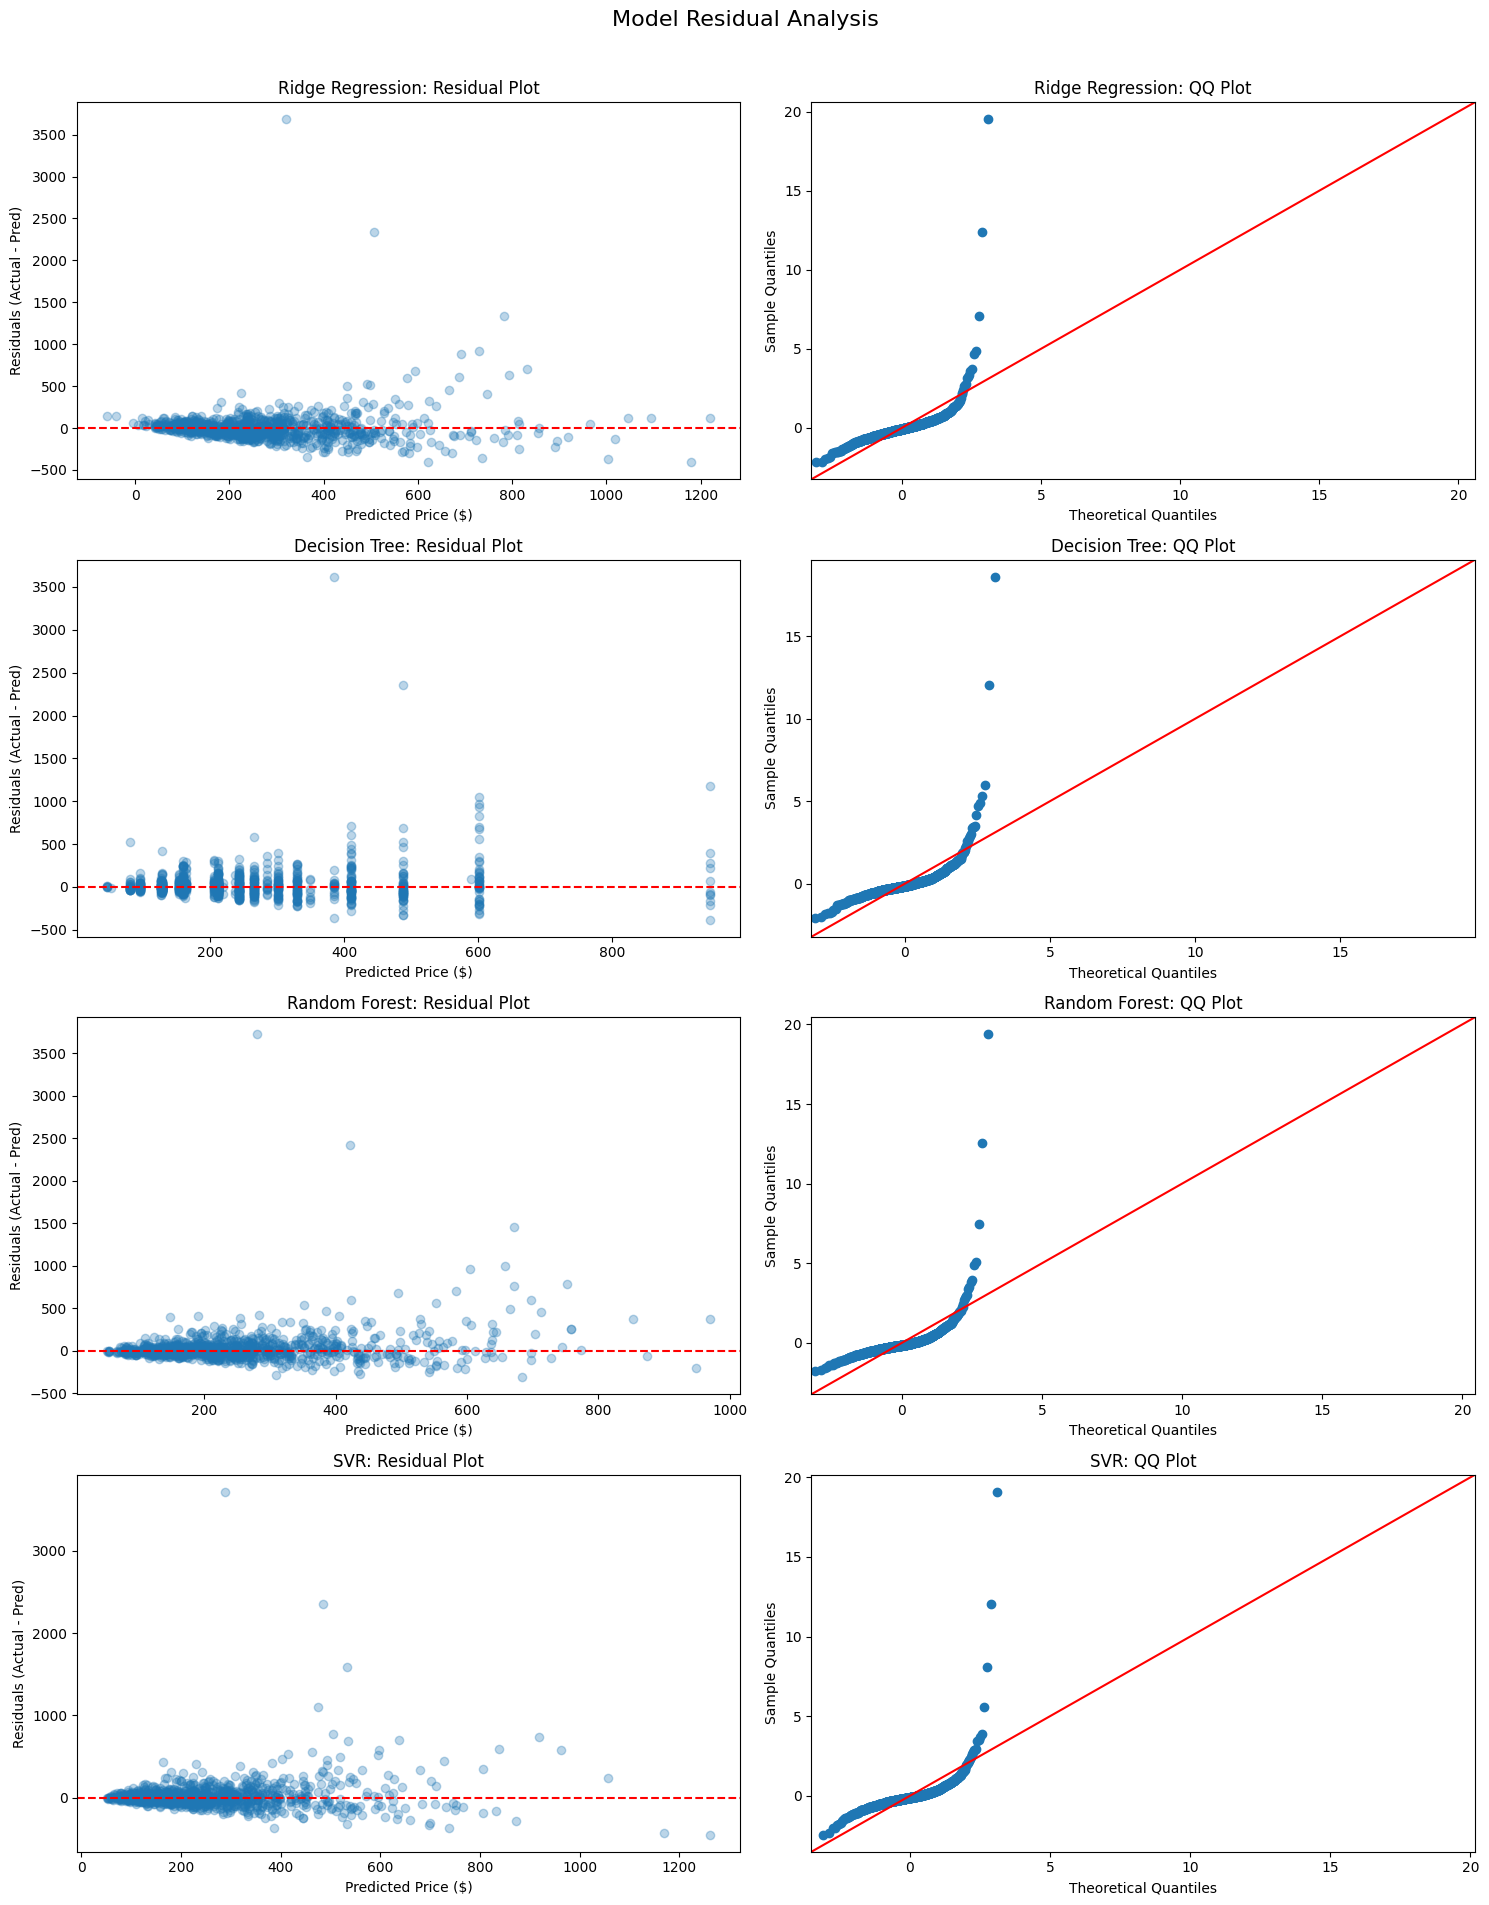


=== FINAL MODEL COMPARISON TABLE ===
| Model            |   RMSE ($) |   R2 Score | Best Params                                                                              |
|:-----------------|-----------:|-----------:|:-----------------------------------------------------------------------------------------|
| Ridge Regression |    188.622 |   0.461968 | {'alpha': 1.0, 'solver': 'auto'}                                                         |
| Random Forest    |    192.521 |   0.439495 | {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None} |
| SVR              |    194.688 |   0.426809 | {'svr__kernel': 'rbf', 'svr__gamma': 'auto', 'svr__epsilon': 0.01, 'svr__C': 1}          |
| Decision Tree    |    194.704 |   0.426715 | {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}                          |

 The Best Performing Model is: Ridge Regression
Justification: It has the lowest RMSE (minimizing dollar error) and the highest R2 (e

In [274]:
# 1. Gather Best Predictions (Ensure variables match your previous cells)


# Dictionary of model results
models = {
    'Ridge Regression': ridge_tuned_predictions,
    'Decision Tree': dt_dollar_pred,
    'Random Forest': rf_pred_dollar,
    'SVR': svr_pred_dollar
}

# 2. Residual Plots & QQ Plots
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Model Residual Analysis', fontsize=16)

for idx, (name, preds) in enumerate(models.items()):
    residuals = price_y_test - preds
    
    # Residual Plot (Predicted vs Residuals)
    axes[idx, 0].scatter(preds, residuals, alpha=0.3)
    axes[idx, 0].axhline(y=0, color='r', linestyle='--')
    axes[idx, 0].set_title(f'{name}: Residual Plot')
    axes[idx, 0].set_xlabel('Predicted Price ($)')
    axes[idx, 0].set_ylabel('Residuals (Actual - Pred)')
    
    # QQ Plot (Normality check)
    sm.qqplot(residuals, line='45', fit=True, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{name}: QQ Plot')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 3. Final Summary Table
summary_data = {
    'Model': [],
    'RMSE ($)': [],
    'R2 Score': [],
    'Best Params': []
}

# Add Ridge Stats
summary_data['Model'].append('Ridge Regression')
summary_data['RMSE ($)'].append(ridge_tuned_rmse)
summary_data['R2 Score'].append(ridge_tuned_r2)
summary_data['Best Params'].append(str(ridge_grid.best_params_))

# Add DT Stats
summary_data['Model'].append('Decision Tree')
summary_data['RMSE ($)'].append(dt_final_rmse)
summary_data['R2 Score'].append(r2_score(price_y_test, dt_dollar_pred))
summary_data['Best Params'].append(str(dt_grid.best_params_))

# Add RF Stats
summary_data['Model'].append('Random Forest')
summary_data['RMSE ($)'].append(rf_rmse)
summary_data['R2 Score'].append(rf_r2)
summary_data['Best Params'].append(str(rf_random.best_params_)) # Using Random as it searched bigger space

# Add SVR Stats
summary_data['Model'].append('SVR')
summary_data['RMSE ($)'].append(svr_rmse)
summary_data['R2 Score'].append(svr_r2)
summary_data['Best Params'].append(str(svr_random.best_params_))

# Create DataFrame
final_comparison = pd.DataFrame(summary_data).sort_values(by='RMSE ($)', ascending=True)

print("\n=== FINAL MODEL COMPARISON TABLE ===")
# Using to_markdown() for a clean table, or simply print the dataframe
try:
    print(final_comparison.to_markdown(index=False))
except:
    print(final_comparison)

# 4. Best Model Declaration
best_model_name = final_comparison.iloc[0]['Model']
print(f"\n The Best Performing Model is: {best_model_name}")
print("Justification: It has the lowest RMSE (minimizing dollar error) and the highest R2 (explaining the most variance).")

## Discussion

1. Ridge Regression Won (RMSE: $188.62, R²: 0.462)
   
   WHY IT PERFORMED BEST:

   • Price has strong LINEAR relationships with features
     (bedrooms, bathrooms, accommodates all scale linearly)
     
   • Regularization (alpha=1.0) prevented overfitting to rare property types

   
   • Log transformation stabilized the target, making linear assumptions valid
   
   TRADE-OFFS:

   
   • Cannot capture complex non-linear interactions
   
   • Assumes all relationships are additive
   
   • May underpredict luxury listings with unique characteristics

2. Random Forest Was Close Second (RMSE: $192.52, R²: 0.440)
   
   WHY IT WAS COMPETITIVE:

   
   • Can capture non-linear patterns (e.g., Downtown listings command premium)
   
   • Ensemble of 200 trees reduces variance
   
   • Automatic feature interaction detection
   
   WHY IT DIDN'T WIN:

   
   • Airbnb pricing is fundamentally linear (size × location = price)
   
   • Extra complexity doesn't help when relationships are simple
   
   • Slightly overfits to training data despite averaging

3. Decision Tree & SVR Underperformed
   
   DECISION TREE ISSUES:

   
   • Even with max_depth=5, still too simple
   
   • Creates step-function predictions (not smooth)
   
   • Cannot extrapolate beyond training data range
   
   SVR ISSUES:

   
   • EXTREMELY slow (8+ minutes for hyperparameter tuning!)
   
   • RBF kernel adds unnecessary complexity for linear problem
   
   • Sensitive to scaling despite using StandardScaler

POSSIBLE DATA CHARACTERISTICS THAT INFLUENCED RESULTS:


- Right-skewed price distribution -> Log transformation critical

- 75 features after one-hot encoding -> Regularization necessary

- Linear base relationships -> Simple models work well

- No extreme non-linearity -> Complex models don't help

 MODEL LIMITATIONS:

All models struggle with:

- Extreme luxury listings (>$500/night) - training data is sparse here

- New property types not in training data

- Seasonal pricing variations (not captured in features)

- Last-minute booking premiums

 POSSIBLE RECOMMENDATIONS:

For Airbnb hosts:

- Use Ridge model for quick, reliable price estimates

- Key drivers: bedrooms (+$80), bathrooms (+$79), Downtown location (+$63)

- Log transformation shows pricing is multiplicative, not additive

For future improvements:

- Collect seasonal/demand data

- Add additional neighborhood details/factor in amenities


- Consider ensemble of Ridge + Random Forest


Regarding Error Metrics:

1. RMSE (Root Mean Squared Error) - PRIMARY METRIC
   
    Chosen because:

   • In dollar units - directly interpretable by hosts
   • Penalizes large errors heavily - important for avoiding $500 mistakes
   • Standard metric for price prediction
   
    Limitation:

   • Sensitive to outliers (luxury listings)
   • Harder to achieve low RMSE with skewed data

2. R² Score (Coefficient of Determination) - SECONDARY METRIC
   
    Chosen because:

   • Shows % of variance explained (46% is decent for real-world data)
   • Normalized metric (easier to compare across datasets)
   • Indicates model's predictive power
   
    Limitation:

   • Can be misleading if model is systematically biased
   • Doesn't tell us about error magnitude

3. MAE (Mean Absolute Error) - SUPPLEMENTARY
   
    Would be useful for:

   • More robust to outliers than RMSE
   • Average error magnitude
   
    Why I didn't prioritize it:

   • Less standard for regression competitions
   • RMSE better matches business cost of large errors

 Why not just Accuracy?

   • Accuracy is for classification (Yes/No predictions)
   • Our target is continuous (price in dollars)
   • Need metrics that measure distance from true value